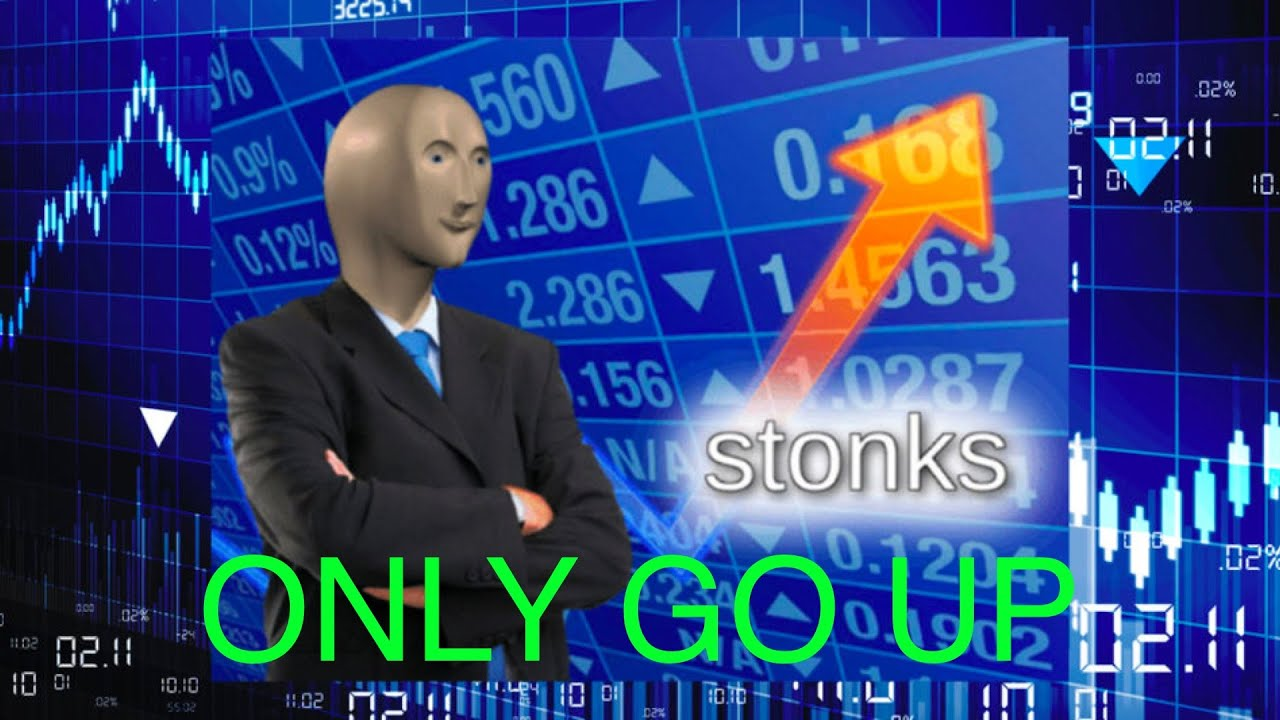

# Predicting Stock Market Prices

This project will attempt to predict stock price of the S&P500 from 1950 to 2015. The S&P500 is a publicly traded index of 500 large companies wrapped in an ETF allowing the index to be traded like an individual stock. 

The columns of the dataset are:

* Date -- The date of the record.
* Open -- The opening price of the day (when trading starts).
* High -- The highest trade price during the day.
* Low -- The lowest trade price during the day.
* Close -- The closing price for the day (when trading is finished).
* Volume -- The number of shares traded.
* Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions, such as a stock split.

#### Conclusion
In this project we used past S&P 500 data to build a linear regression model whose goal was to predict the price of the S&P 500. The composition of this model was past data transformed into indicators of a rising or falling price. 

Unfortunately, our model will not make us rich. From a birds eye view it appears that our model tracked nicely with the price of the S&P, but beware, each predicition is only a day forward, so the prediction is likely to be within some small standard deviation window of the actual price. 

While we were able to lower our variance by adjusting feature selection and our train/test ratios, the standard error does not fall within an acceptable loss window. 

Evaluating the final actual vs predicted graph, our predictions looks more like a time delayed version of the actual values, which is of little value when performing high-risk activities like stock trading.

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

In [2]:
stocks = pd.read_csv("sphist.csv")

In [3]:
stocks.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [4]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


There are 16,590 rows of data, each representing a snapshot of the index for the day. There are 7 columns, date and varying price metrics. There are no missing rows values. 

## Data Cleaning

The `Date` column is in string object format, let's transform this into a datetime object so that we can perform time series analysis.

In [5]:
stocks['Date'] = pd.to_datetime(stocks['Date'], format = '%Y/%m/%d')
print(stocks['Date'].dtype)

datetime64[ns]


Let's validate that the dates are within the expected range.

We expect our dates to have a snapshot of everyday between 1950 and 2015.

In [6]:
stocks = stocks.sort_values(by = 'Date', ascending = True).reset_index(drop = True)
print(stocks['Date'].head())
print(stocks['Date'].tail())

0   1950-01-03
1   1950-01-04
2   1950-01-05
3   1950-01-06
4   1950-01-09
Name: Date, dtype: datetime64[ns]
16585   2015-12-01
16586   2015-12-02
16587   2015-12-03
16588   2015-12-04
16589   2015-12-07
Name: Date, dtype: datetime64[ns]


In [7]:
duplicates = stocks[stocks.duplicated(['Date'])]
print(len(duplicates))

0


Our dates are within the expected allotment and contain no duplicates. We will ignore any days where there were no trades and assume that these days were days the stock exchange was closed.

## Creating Indicators
Each observation of the S&P500 is dependent on those observations coming before it, i.e. the sell price today is dependent on the sell price yesterday. When we create indicators, we need to ensure that the indicators consider only the past, even though we have access to a large timeline of data and hindsight (this project was created in 2022). Indicators created with future knowledge will create a model that appears to be very successful when used on test data, but if used in the real world would not net good results.

Let's generate some indicators:

* The average price from the past 5 days.
* The average price for the past 30 days.
* The average price for the past 365 days.
* The ratio between the average price for the past 5 days, and the average price for the past 365 days.
* The standard deviation of the price over the past 5 days.
* The standard deviation of the price over the past 365 days.
* The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.

These indicators are for active trading days and will not take into consideration the row of the observation itself in the metric, as doing so would 'telegraph' the prediction.

### Rolling Average Inidicators 
The rolling average takes a specified period of time and consistently recalculates it for each row of data, not including the row of data itself. Let's create these rolling windows for 5, 30, and 365 trading days in the past. 

In [8]:
def rolling_average(row, window):
    index = row.name
    if window > index:
        return 0
    window_end = index # do not consider the row itself
    window_start = index - window 
    
    rolling_average = stocks['Close'].iloc[window_start:window_end].mean()
    
    return rolling_average

In [9]:
stocks['Five Day Average'] = stocks.apply(rolling_average,window = 5, axis = 1)
stocks['Thirty Day Average'] = stocks.apply(rolling_average, window = 30, axis = 1)
stocks['Year Average'] = stocks.apply(rolling_average, window = 365, axis = 1)

In [10]:
stocks.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,Five Day Average,Thirty Day Average,Year Average
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,0.000,0.0,0.0
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,0.000,0.0,0.0
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,0.000,0.0,0.0
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,0.000,0.0,0.0
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,0.000,0.0,0.0
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,0.0,0.0
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,0.0,0.0
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,0.0,0.0
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,0.0,0.0
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,0.0,0.0


In [11]:
# check that we get the same result with a manual calculation
stocks['Close'].sort_index().iloc[0:5]

0    16.66
1    16.85
2    16.93
3    16.98
4    17.08
Name: Close, dtype: float64

In [12]:
stocks['Close'].sort_index().iloc[0:5].mean()

16.9

### Ratio Between 5 Day and 365 Day Average

This ratio will give us an indication of the S&P's current average value compared with its average value over the year. If the ratio is above one, then it is above it's average yearly price.

In [13]:
def short_long_ratio(row):
    index = row.name
    if 365 > int(index):
        return 0
    
    short_long_ratio = row['Five Day Average'] / row['Year Average']
    
    return short_long_ratio

In [14]:
stocks['Five Day to Year Ratio'] = stocks.apply(short_long_ratio, axis = 1)

In [15]:
stocks.tail(2)

,Date,Open,High,Low,Close,Volume,Adj Close,Five Day Average,Thirty Day Average,Year Average,Five Day to Year Ratio
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343,1.021580
16589,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.771973,2080.237329,2036.869425,1.021554


### Rolling Average Standard Deviation 
The standard deviation will give us an indication of the variability/volatility of the index. Let's create a short and long term indicator.

In [16]:
def rolling_average_std(row, window):
    index = row.name
    if window > index:
        return 0
    window_end = index # do not consider the row itself
    window_start = index - window 
    
    rolling_std = stocks['Close'].iloc[window_start:window_end].std()
    
    return rolling_std

In [17]:
stocks['Five Day Std'] = stocks.apply(rolling_average_std,window = 5, axis = 1)
stocks['Year Average Std'] = stocks.apply(rolling_average_std, window = 365, axis = 1)

In [18]:
stocks.tail(2)

,Date,Open,High,Low,Close,Volume,Adj Close,Five Day Average,Thirty Day Average,Year Average,Five Day to Year Ratio,Five Day Std,Year Average Std
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343,1.021580,19.599946,64.121622
16589,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.771973,2080.237329,2036.869425,1.021554,19.806136,64.058862


### Ratio Between 5 Day and 365 Day Standard Deviation

A comparison of short variability in the short and long term will be an indicator as to whether the variability has increased or decreased in the short term.

In [19]:
def short_long_ratio_std(row):
    index = row.name
    if 365 > int(index):
        return 0
    
    short_long_ratio = row['Five Day Std'] / row['Year Average Std']
    
    return short_long_ratio

In [20]:
stocks['Five Day to Year Std Ratio'] = stocks.apply(short_long_ratio_std, axis = 1)

In [21]:
stocks[['Five Day Std', 'Year Average Std','Five Day to Year Std Ratio']].tail(2)

,Five Day Std,Year Average Std,Five Day to Year Std Ratio
16588,19.599946,64.121622,0.305668
16589,19.806136,64.058862,0.309187


## Dropping Incomplete Rows 
The indicators we created range from a 5 to 365 day look back, and not every row will have a metric. In the example of a 5 day lookback, we weren't able to calculate the indicator until day 6. The model we build will need non-zero entries for every row, so let's filter our dataset of rows with zero values.

In [22]:
stocks_for_model = stocks.iloc[365:].reset_index(drop = True)

In [23]:
len(stocks_for_model)

16225

In [24]:
stocks_for_model.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Five Day Average,Thirty Day Average,Year Average,Five Day to Year Ratio,Five Day Std,Year Average Std,Five Day to Year Std Ratio
0,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,1.120954,0.256223,1.790253,0.143121
1,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,1.125246,0.213659,1.789307,0.119409
2,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,1.128142,0.092574,1.788613,0.051758
3,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562,1.126757,0.115108,1.787659,0.064390
4,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082,1.121008,0.204132,1.786038,0.114293


## Training the Model
Let's now build our Linear Regression Model and assess it's performance.

In [25]:
def train_test(df, features):    
    # define the target
    target = 'Close'
    
    train = df[:round(len(df)*.8)]
    test = df[round(len(df)*.8):]

    model = LinearRegression()
    model.fit(train[features], train[target])

    predictions = model.predict(test[features])
    variance = np.var(predictions)

    rmse = np.sqrt(np.absolute(mean_squared_error(test[target], predictions)))
    return rmse, variance, predictions, test
    

In [26]:
feature_list = list(stocks.iloc[:,-7:])
feature_list

['Five Day Average',
 'Thirty Day Average',
 'Year Average',
 'Five Day to Year Ratio',
 'Five Day Std',
 'Year Average Std',
 'Five Day to Year Std Ratio']

In [27]:
rmse, var, predictions, test = train_test(stocks_for_model, feature_list)

In [28]:
print(rmse, var)

19.801752462509807 111315.79234237914


In [29]:
stock_predictions = test.copy()
stock_predictions['predictions'] = predictions

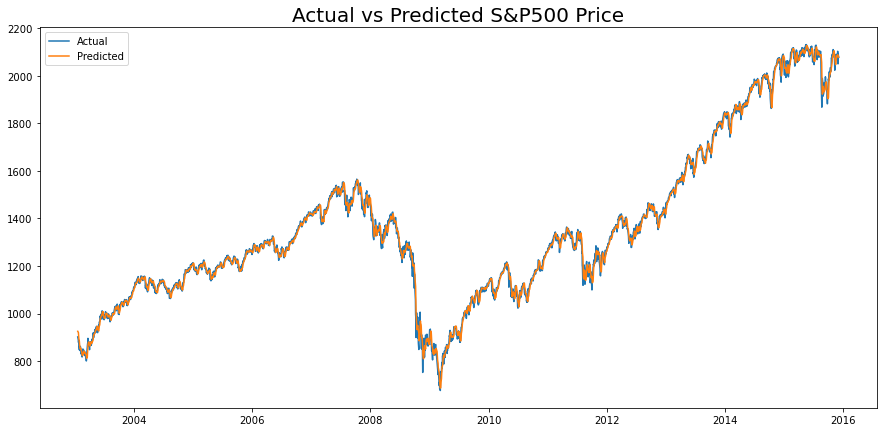

In [30]:
plt.figure(figsize = (15,7))
plt.plot(stock_predictions['Date'],stock_predictions['Close'], label = 'Actual')
plt.plot(stock_predictions['Date'], stock_predictions['predictions'], label = 'Predicted')
plt.title('Actual vs Predicted S&P500 Price', fontsize = 20)
plt.legend()
plt.show()

When we graph our results it appears that our predictions are accurate, however we must take into account that each prediction is for one day in the future. When trading at such a small window, even small margins of error can result in lost investment. Let's see if we can reduce our error and variance further with some additional indicators.

## Adding Additional Indicators
Let's add some additional indicators to see if we can improve our model. 
* Volume indicators
* Rolling window distances from lowest and highest prices
* Date related indicators, such as day of week

### Volume Indicators
#### Rolling Average

In [31]:
def rolling_volume_average(row, window):
    index = row.name
    if window > index:
        return 0
    window_end = index # do not consider the row itself
    window_start = index - window 
    
    rolling_average = stocks['Volume'].iloc[window_start:window_end].mean()
    
    return rolling_average

In [32]:
stocks['Five Day Average Volume'] = stocks.apply(rolling_volume_average,window = 5, axis = 1)
stocks['Thirty Day Average Volume'] = stocks.apply(rolling_volume_average, window = 30, axis = 1)
stocks['Year Average Volume'] = stocks.apply(rolling_volume_average, window = 365, axis = 1)

In [33]:
stocks[['Volume','Five Day Average Volume', 'Thirty Day Average Volume', 'Year Average Volume']].tail()

,Volume,Five Day Average Volume,Thirty Day Average Volume,Year Average Volume
16585,3.712120e+09,3.207544e+09,3.842181e+09,3.527800e+09
16586,3.950640e+09,3.232372e+09,3.856341e+09,3.526090e+09
16587,4.306490e+09,3.245514e+09,3.876979e+09,3.529468e+09
16588,4.214910e+09,3.536224e+09,3.899603e+09,3.532802e+09
16589,4.043820e+09,4.085838e+09,3.892405e+09,3.535838e+09


#### Short to Long Volume Ratio

In [34]:
def short_long_ratio_volume(row):
    index = row.name
    if 365 > int(index):
        return 0
    
    short_long_ratio = row['Five Day Average Volume'] / row['Year Average Volume']
    
    return short_long_ratio

In [35]:
stocks['Five Day to Year Volume Ratio'] = stocks.apply(short_long_ratio_volume, axis = 1)

#### Volume Standard Deviation

In [36]:
def rolling_average_volume_std(row, window):
    index = row.name
    if window > index:
        return 0
    window_end = index # do not consider the row itself
    window_start = index - window 
    
    rolling_std = stocks['Volume'].iloc[window_start:window_end].std()
    
    return rolling_std

In [37]:
stocks['Five Day Volume Std'] = stocks.apply(rolling_average_volume_std,window = 5, axis = 1)
stocks['Year Average Volume Std'] = stocks.apply(rolling_average_volume_std, window = 365, axis = 1)

#### Ratio Between Short and Long Term Volume Standard Deviation

In [38]:
def short_long_volume_ratio_std(row):
    index = row.name
    if 365 > int(index):
        return 0
    
    short_long_ratio = row['Five Day Volume Std'] / row['Year Average Volume Std']
    
    return short_long_ratio

In [39]:
stocks['Five Day to Year Volume Std Ratio'] = stocks.apply(short_long_volume_ratio_std, axis = 1)

### Highs and Lows
The short, medium, and long-term highs and lows may also be a good indicator. Let's add these for both `Close` and `Volume`.

In [40]:
def rolling_extremes(row, window, metric, high = True):
    index = row.name
    if window > index:
        return 0
    window_end = index # do not consider the row itself
    window_start = index - window 
    
    if high == True:
        extreme = stocks[metric].iloc[window_start:window_end].max()
    else:
        extreme = stocks[metric].iloc[window_start:window_end].min()
    
    return extreme

In [41]:
stocks['Five Day High'] = stocks.apply(rolling_extremes,window = 5, metric = 'Close', axis = 1)
stocks['Thirty Day High'] = stocks.apply(rolling_extremes, window = 30,metric = 'Close', axis = 1)
stocks['Year High'] = stocks.apply(rolling_extremes, window = 365, metric = 'Close', axis = 1)
stocks['Five Day Low'] = stocks.apply(rolling_extremes,window = 5, metric = 'Close', high = False, axis = 1)
stocks['Thirty Day Low'] = stocks.apply(rolling_extremes, window = 30,metric = 'Close', high = False, axis = 1)
stocks['Year Low'] = stocks.apply(rolling_extremes, window = 365, metric = 'Close', high = False, axis = 1)

stocks['Five Day Volume High'] = stocks.apply(rolling_extremes,window = 5, metric = 'Volume', axis = 1)
stocks['Thirty Day Volume High'] = stocks.apply(rolling_extremes, window = 30,metric = 'Volume', axis = 1)
stocks['Year Volume High'] = stocks.apply(rolling_extremes, window = 365, metric = 'Volume', axis = 1)
stocks['Five Day Volume Low'] = stocks.apply(rolling_extremes,window = 5, metric = 'Volume', high = False, axis = 1)
stocks['Thirty Day Volume Low'] = stocks.apply(rolling_extremes, window = 30,metric = 'Volume', high = False, axis = 1)
stocks['Year Volume Low'] = stocks.apply(rolling_extremes, window = 365, metric = 'Volume', high = False, axis = 1)

In [42]:
stocks

,Date,Open,High,Low,Close,Volume,Adj Close,Five Day Average,Thirty Day Average,Year Average,...,Year High,Five Day Low,Thirty Day Low,Year Low,Five Day Volume High,Thirty Day Volume High,Year Volume High,Five Day Volume Low,Thirty Day Volume Low,Year Volume Low
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1.260000e+06,16.660000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1.890000e+06,16.850000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2.550000e+06,16.930000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2.010000e+06,16.980000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2.520000e+06,17.080000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2035.531178,...,2130.820068,2080.409912,2018.939941,1862.48999,4.245030e+09,4.698110e+09,6.612690e+09,1.466840e+09,1.466840e+09,536200000.0
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.914082,...,2130.820068,2080.409912,2018.939941,1862.48999,4.245030e+09,4.698110e+09,6.612690e+09,1.466840e+09,1.466840e+09,536200000.0
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2036.234356,...,2130.820068,2079.510010,2018.939941,1862.48999,4.245030e+09,4.698110e+09,6.612690e+09,1.466840e+09,1.466840e+09,536200000.0
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343,...,2130.820068,2049.620117,2023.040039,1862.48999,4.306490e+09,4.698110e+09,6.612690e+09,1.466840e+09,1.466840e+09,536200000.0


#### Current to Extreme Comparison
More interesting would be a comparison of the current price or trade volume and the extreme, this will give an idea of distance from those extreme points. 

In [43]:
def extreme_comparisons(row, metric, comparison):
    index = row.name
    if 365 > int(index):
        return 0
    yesterday_index = index - 1
    
    yesterday_metric = stocks[metric].iloc[yesterday_index]
    
    extreme_comparison = yesterday_metric / row[comparison]
    
    return extreme_comparison

In [44]:
extreme_comparisons(stocks.iloc[16589],'Close', 'Five Day Low')

1.0205256689525357

In [45]:
stocks['Five Day High Ratio'] = stocks.apply(extreme_comparisons, metric = 'Close', comparison = 'Five Day High', axis = 1)
stocks['Thirty Day High Ratio'] = stocks.apply(extreme_comparisons,metric = 'Close', comparison = 'Thirty Day High', axis = 1)
stocks['Year High Ratio'] = stocks.apply(extreme_comparisons, metric = 'Close', comparison = 'Year High', axis = 1)
stocks['Five Day Low Ratio'] = stocks.apply(extreme_comparisons, metric = 'Close',comparison = 'Five Day Low', axis = 1)
stocks['Thirty Day Low Ratio'] = stocks.apply(extreme_comparisons, metric = 'Close', comparison = 'Thirty Day Low', axis = 1)
stocks['Year Low Ratio'] = stocks.apply(extreme_comparisons, metric = 'Close', comparison = 'Year Low', axis = 1)

stocks['Five Day Volume High Ratio'] = stocks.apply(extreme_comparisons, comparison = 'Five Day Volume High', metric = 'Volume', axis = 1)
stocks['Thirty Day Volume High Ratio'] = stocks.apply(extreme_comparisons, comparison = 'Thirty Day Volume High', metric = 'Volume', axis = 1)
stocks['Year Volume High Ratio'] = stocks.apply(extreme_comparisons, metric = 'Volume', comparison = 'Year Volume High', axis = 1)
stocks['Five Day Volume Low Ratio'] = stocks.apply(extreme_comparisons, metric = 'Volume', comparison = 'Five Day Volume Low', axis = 1)
stocks['Thirty Day Volume Low Ratio'] = stocks.apply(extreme_comparisons,metric = 'Volume', comparison = 'Thirty Day Volume Low', axis = 1)
stocks['Year Volume Low Ratio'] = stocks.apply(extreme_comparisons, metric = 'Volume', comparison = 'Year Volume Low', axis = 1)

### Day of Week Indicators
The day a trade takes place can have an impact on price. Let's add that for our model's consideration.

In [46]:
stocks['Day of Week'] = stocks['Date'].dt.dayofweek

In [47]:
stocks

,Date,Open,High,Low,Close,Volume,Adj Close,Five Day Average,Thirty Day Average,Year Average,...,Five Day Low Ratio,Thirty Day Low Ratio,Year Low Ratio,Five Day Volume High Ratio,Thirty Day Volume High Ratio,Year Volume High Ratio,Five Day Volume Low Ratio,Thirty Day Volume Low Ratio,Year Volume Low Ratio,Day of Week
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1.260000e+06,16.660000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1.890000e+06,16.850000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2.550000e+06,16.930000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2.010000e+06,16.980000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2.520000e+06,17.080000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2035.531178,...,1.000000,1.030447,1.117005,1.000000,0.903561,0.641952,2.893997,2.893997,7.916878,1
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.914082,...,1.010681,1.041452,1.128935,0.874463,0.790130,0.561363,2.530692,2.530692,6.923014,2
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2036.234356,...,1.000000,1.030001,1.116521,0.930651,0.840900,0.597433,2.693300,2.693300,7.367848,3
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343,...,1.000000,1.013139,1.100473,1.000000,0.916643,0.651246,2.935896,2.935896,8.031499,4


### Dropping Incomplete Rows

In [48]:
stocks_for_model = stocks.iloc[365:].reset_index(drop = True)

## Training the Model
Let's now build our Linear Regression Model and assess it's performance.

In [49]:
def train_test(df, features):    
    # define the target
    target = 'Close'
    
    train = df[:round(len(df)*.8)]
    test = df[round(len(df)*.8):]

    model = LinearRegression()
    model.fit(train[features], train[target])

    predictions = model.predict(test[features])
    variance = np.var(predictions)

    rmse = np.sqrt(np.absolute(mean_squared_error(test[target], predictions)))
    return rmse, variance, predictions, test
    

In [50]:
feature_list = list(stocks.iloc[:,7:])
feature_list

['Five Day Average',
 'Thirty Day Average',
 'Year Average',
 'Five Day to Year Ratio',
 'Five Day Std',
 'Year Average Std',
 'Five Day to Year Std Ratio',
 'Five Day Average Volume',
 'Thirty Day Average Volume',
 'Year Average Volume',
 'Five Day to Year Volume Ratio',
 'Five Day Volume Std',
 'Year Average Volume Std',
 'Five Day to Year Volume Std Ratio',
 'Five Day High',
 'Thirty Day High',
 'Year High',
 'Five Day Low',
 'Thirty Day Low',
 'Year Low',
 'Five Day Volume High',
 'Thirty Day Volume High',
 'Year Volume High',
 'Five Day Volume Low',
 'Thirty Day Volume Low',
 'Year Volume Low',
 'Five Day High Ratio',
 'Thirty Day High Ratio',
 'Year High Ratio',
 'Five Day Low Ratio',
 'Thirty Day Low Ratio',
 'Year Low Ratio',
 'Five Day Volume High Ratio',
 'Thirty Day Volume High Ratio',
 'Year Volume High Ratio',
 'Five Day Volume Low Ratio',
 'Thirty Day Volume Low Ratio',
 'Year Volume Low Ratio',
 'Day of Week']

In [51]:
rmse, var, predictions, test = train_test(stocks_for_model, feature_list)

In [52]:
print(rmse, var)

38.03969650436348 103993.46818081365


In [53]:
stock_predictions = test.copy()
stock_predictions['predictions'] = predictions

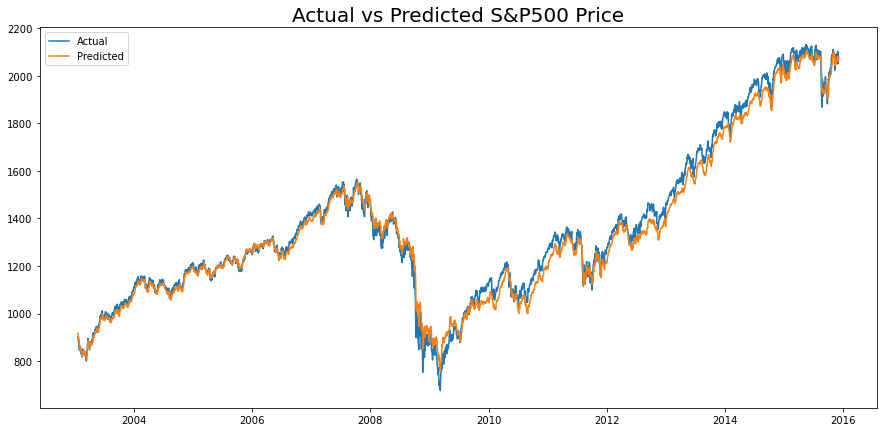

In [54]:
plt.figure(figsize = (15,7))
plt.plot(stock_predictions['Date'],stock_predictions['Close'], label = 'Actual')
plt.plot(stock_predictions['Date'], stock_predictions['predictions'], label = 'Predicted')
plt.title('Actual vs Predicted S&P500 Price', fontsize = 20)
plt.legend()
plt.show()

Our model is overfit. Let's go through some feature selection to pick the most appropriate features.

### Feature Selection
Let's target columns that are highly correlated with `Close`.

In [55]:
correlation_columns = feature_list
correlation_columns.append('Close')

In [56]:
correlation_df = stocks_for_model[correlation_columns]

In [57]:
close_correlations = correlation_df.corr()['Close'].abs().sort_values(ascending = False)[1:]
close_correlations

Five Day Average                     0.999793
Five Day Low                         0.999759
Five Day High                        0.999737
Thirty Day Average                   0.999189
Thirty Day Low                       0.999082
Thirty Day High                      0.998809
Year Low                             0.989595
Year Average                         0.988870
Year High                            0.986240
Year Average Std                     0.816103
Year Volume Low                      0.807718
Thirty Day Average Volume            0.786908
Year Average Volume                  0.784878
Five Day Average Volume              0.780896
Five Day Volume Low                  0.778407
Five Day Volume High                 0.770990
Thirty Day Volume High               0.767984
Thirty Day Volume Low                0.757409
Year Volume High                     0.735346
Five Day Std                         0.722414
Year Average Volume Std              0.684141
Five Day Volume Std               

Let's set a filter to keep any metrics above .70.

In [58]:
close_high_correlations = close_correlations[close_correlations > 0.9]
close_high_correlations

Five Day Average      0.999793
Five Day Low          0.999759
Five Day High         0.999737
Thirty Day Average    0.999189
Thirty Day Low        0.999082
Thirty Day High       0.998809
Year Low              0.989595
Year Average          0.988870
Year High             0.986240
Name: Close, dtype: float64

In [59]:
new_targets = list(close_high_correlations.index)

## Training the Model
Let's now build our Linear Regression Model and assess it's performance. One change we will make is to greatly shorten the train and test window. This will give us more data to train with and a smaller performance evaluation window so we can better understand our ability to make short term predictions.

In [60]:
def train_test(df, features):    
    # define the target
    target = 'Close'
    
    train = df[:round(len(df)*.99)]
    test = df[round(len(df)*.99):]

    model = LinearRegression()
    model.fit(train[features], train[target])

    predictions = model.predict(test[features])
    variance = np.var(predictions)

    rmse = np.sqrt(np.absolute(mean_squared_error(test[target], predictions)))
    return rmse, variance, predictions, test
    

In [61]:
rmse, var, predictions, test = train_test(stocks_for_model, new_targets)

In [62]:
actual_var = np.var(test['Close'])

In [63]:
print(rmse, var, actual_var)

28.809182921887178 4043.1169074901495 4086.519736652718


In [64]:
stock_predictions = test.copy()
stock_predictions['predictions'] = predictions

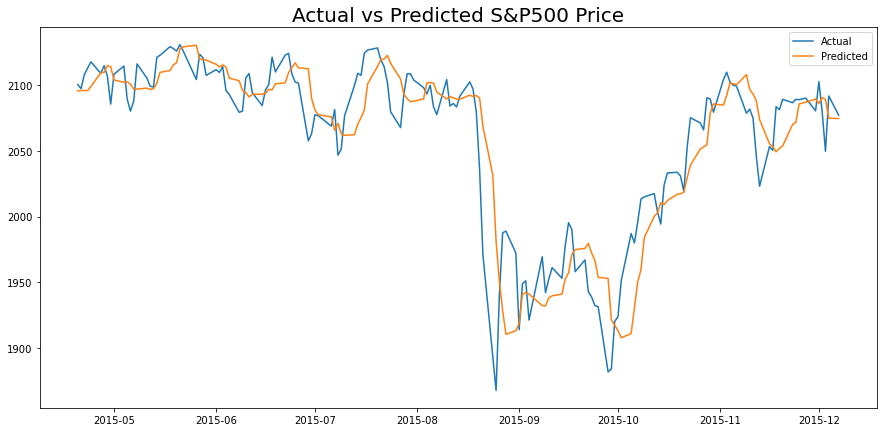

In [65]:
plt.figure(figsize = (15,7))
plt.plot(stock_predictions['Date'],stock_predictions['Close'], label = 'Actual')
plt.plot(stock_predictions['Date'], stock_predictions['predictions'], label = 'Predicted')
plt.title('Actual vs Predicted S&P500 Price', fontsize = 20)
plt.legend()
plt.show()

## Conclusion
In this project we used past S&P 500 data to build a linear regression model whose goal was to predict the price of the S&P 500. The composition of this model was past data transformed into indicators of a rising or falling price. 

Unfortunately, our model will not make us rich. From a birds eye view it appears that our model tracked nicely with the price of the S&P, but beware, each predicition is only a day forward, so the prediction is likely to be within some small standard deviation window of the actual price. 

While we were able to lower our variance by adjusting feature selection and our train/test ratios, the standard error does not fall within an acceptable loss window. 

Evaluating the final actual vs predicted graph, our predictions looks more like a time delayed version of the actual values, which is of little value when performing high-risk activities like stock trading.